In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
df = pd.read_csv('../3OEC_current_flow.csv')

df["O2_avg"] = df[["O2_S1", "O2_S2", "O2_S3"]].mean(axis=1)

In [3]:
def MARE(prediction_tensor, truth_tensor):
    return torch.sum(torch.abs((prediction_tensor - truth_tensor)/truth_tensor))/truth_tensor.numel()

In [4]:
from datetime import datetime, timedelta

start_time_11 = datetime(2017, 7, 11, 14, 0, 0)
end_time_11 = datetime(2017, 7, 12, 8, 0, 0)

start_time_13 = datetime(2017, 7, 13, 11, 0, 0)
end_time_13 = datetime(2017, 7, 14, 6, 0, 0)

start_time_15 = datetime(2017, 7, 15, 10, 0, 0)
end_time_15 = datetime(2017, 7, 16, 6, 0, 0)

start_time_16 = datetime(2017, 7, 16, 16, 0, 0)
end_time_16 = datetime(2017, 7, 17, 6, 0, 0)

deployments = {
    "3oec_2017_7_11_12": {"start": start_time_11, "end": end_time_11},
    "3oec_2017_7_13_14": {"start": start_time_13, "end": end_time_13},
    "3oec_2017_7_15_16": {"start": start_time_15, "end": end_time_15},
    "3oec_2017_7_16_17": {"start": start_time_16, "end": end_time_16}
}

date_ranges = []

for deployment_name, deployment_info in deployments.items():
    start_time = deployment_info["start"]
    end_time = deployment_info["end"]
    if deployment_name == "3oec_2017_7_13_14":
        start_time -= timedelta(seconds=0.125)
    print(start_time)

    # Calculate total seconds and number of measurements
    total_seconds = (end_time - start_time).total_seconds() + 0.125
    num_measurements = int(total_seconds * 8)

    # Create DatetimeIndex for the deployment
    date_range = pd.date_range(start=start_time, periods=num_measurements, freq=f'{1000/8}ms')
    print(date_range[0], date_range[-1])
    print(len(date_range))
    date_ranges.append(pd.Series(date_range))

# Concatenate all DatetimeIndexes
complete_index = pd.concat(date_ranges)

# Set the complete index to your DataFrame
df.index = complete_index

2017-07-11 14:00:00
2017-07-11 14:00:00 2017-07-12 08:00:00
518401
2017-07-13 10:59:59.875000
2017-07-13 10:59:59.875000 2017-07-14 06:00:00
547202
2017-07-15 10:00:00
2017-07-15 10:00:00 2017-07-16 06:00:00
576001
2017-07-16 16:00:00
2017-07-16 16:00:00 2017-07-17 06:00:00
403201


In [5]:
# drop deployment column and resample
df_resampled = df.drop(columns=['deployment', 't', 't_increase', 'Vx', 'Vy', 'Vz', 'P', 'O2_S1', 'O2_S2', 'O2_S3']).resample('5min').mean()

In [6]:
first_piece = df_resampled["2017-07-11":"2017-07-12 06:00:00"]
second_piece = df_resampled["2017-07-13 12:00:00":"2017-07-14 06:00:00"]
third_piece = df_resampled["2017-07-15 12:00:00":"2017-07-16 6:00:00"]
fourth_piece = df_resampled["2017-07-16 16:00:00":"2017-07-17"]

In [7]:
# Split the data into train, val, test (70-20-10)

column_indices = {name: i for i, name in enumerate(first_piece.columns)}
n = len(first_piece)
train_df1 =first_piece[0:int(n*0.6)]
val_df1 = first_piece[int(n*0.6):int(n*0.8)]
test_df1 = first_piece[int(n*0.8):]


In [8]:
# Normalize the data (each partition separately)
train_mean1 = train_df1.mean()
train_std1 = train_df1.std()

train_df1 = (train_df1 - train_mean1) / train_std1
val_df1 = (val_df1 - train_mean1) / train_std1
test_df1 = (test_df1 - train_mean1) / train_std1

In [9]:
def create_sequences(data, seq_length):
    sequences = []
    targets = []
    
    for i in range(len(data) - seq_length):
        sequences.append(data[i:i+seq_length])   # Sequence of `seq_length`
        targets.append(data[i+seq_length])       # Next value as target
    
    return np.array(sequences), np.array(targets)

In [10]:
train_seq1, train_labels1 = create_sequences(train_df1.values, 12)
val_seq1, val_labels1 = create_sequences(val_df1.values, 12)
test_seq1, test_labels1 = create_sequences(test_df1.values, 12)

In [11]:
# Convert to PyTorch tensors
train_seq_tensor1 = torch.FloatTensor(train_seq1)  # (batch, seq_length, input_dim)
train_label_tensor1 = torch.FloatTensor(train_labels1) # (batch, output_dim)
val_seq_tensor1 = torch.FloatTensor(val_seq1)  # (batch, seq_length, input_dim)
val_label_tensor1 = torch.FloatTensor(val_labels1)  # (batch, output_dim)
test_seq_tensor1 = torch.FloatTensor(test_seq1)  # (batch, seq_length, input_dim)
test_labels_tensor1 = torch.FloatTensor(test_labels1)  # (batch, output_dim)

In [12]:
class LSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(LSTMModel, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)
    
    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).to(x.device)  # Initial hidden state
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).to(x.device)  # Initial cell state
        
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])  # Take the last time step output
        return out

# Model parameters
input_dim = 1
hidden_dim = 50
num_layers = 2
output_dim = 1

# Instantiate model
model1 = LSTMModel(input_dim, hidden_dim, num_layers, output_dim)
model1 = model1.to("cpu")  # Use "cuda" if you have a GPU


In [13]:
criterion = nn.MSELoss()
optimizer = optim.Adam(model1.parameters(), lr=0.01)

In [14]:
num_epochs = 100
train_losses = []
val_losses = []

for epoch in range(num_epochs):
    model1.train()
    
    optimizer.zero_grad()
    y_pred = model1(train_seq_tensor1)
    
    loss = criterion(y_pred, train_label_tensor1)
    loss.backward()
    optimizer.step()
    
    train_losses.append(loss.item())

    # Validation
    model1.eval()
    with torch.no_grad():
        y_val = model1(val_seq_tensor1)
        val_loss = criterion(y_val, val_label_tensor1)
        val_losses.append(val_loss.item())
    
    if epoch % 10 == 0:
        print(f'Epoch {epoch}, Train Loss: {loss.item()}, Val Loss: {val_loss.item()}')


Epoch 0, Train Loss: 0.9653183221817017, Val Loss: 5.297915935516357
Epoch 10, Train Loss: 0.09449183195829391, Val Loss: 2.132751941680908
Epoch 20, Train Loss: 0.030573520809412003, Val Loss: 1.2050009965896606
Epoch 30, Train Loss: 0.020981093868613243, Val Loss: 0.6276576519012451
Epoch 40, Train Loss: 0.01574649102985859, Val Loss: 0.1764366328716278
Epoch 50, Train Loss: 0.01338338851928711, Val Loss: 0.0731169581413269
Epoch 60, Train Loss: 0.012543851509690285, Val Loss: 0.06626897305250168
Epoch 70, Train Loss: 0.012173999100923538, Val Loss: 0.055376697331666946
Epoch 80, Train Loss: 0.011810138821601868, Val Loss: 0.05969984829425812
Epoch 90, Train Loss: 0.01137459184974432, Val Loss: 0.05824173986911774


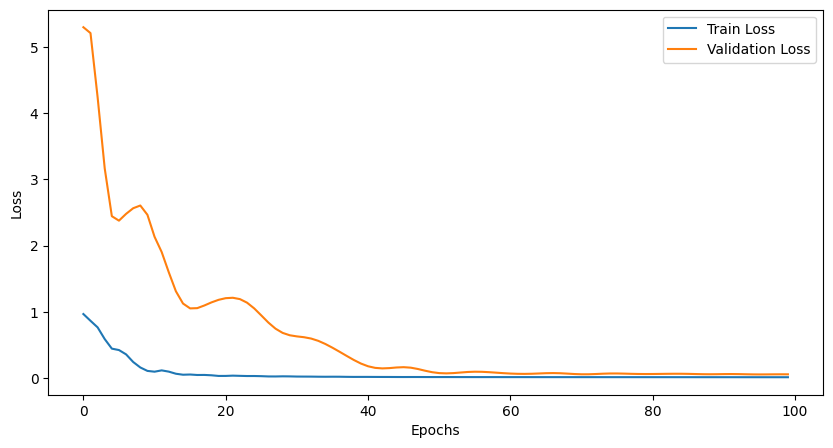

In [15]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()


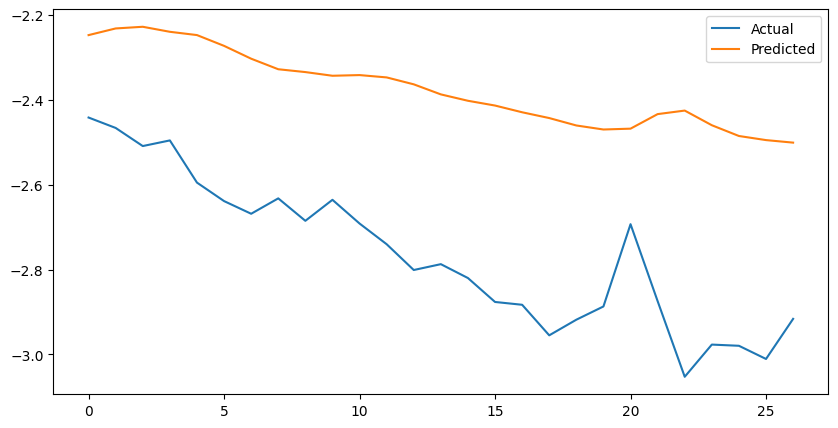

In [16]:
model1.eval()
with torch.no_grad():
    y_pred_test = model1(test_seq_tensor1)

# Plot test predictions
plt.figure(figsize=(10, 5))
plt.plot(test_labels_tensor1.numpy(), label="Actual")
plt.plot(y_pred_test.numpy(), label="Predicted")
plt.legend()
plt.show()


In [17]:
mae = criterion(y_pred_test, test_labels_tensor1)
print(f'Mean Absolute Error: {mae.item()}')
print(f'MARE: {MARE(y_pred_test, test_labels_tensor1)}')

Mean Absolute Error: 0.16235654056072235
MARE: 0.13947533071041107


In [18]:
test_seq_tensor1.shape

torch.Size([27, 12, 1])

In [19]:
np.concatenate((train_df1, val_df1, test_df1), axis=0).shape

(193, 1)

In [20]:
zeros = np.zeros((166,1))

In [21]:
y_pred_test.numpy().shape

(27, 1)

In [22]:
np.concatenate((zeros, y_pred_test.numpy()), axis=0)

array([[ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0

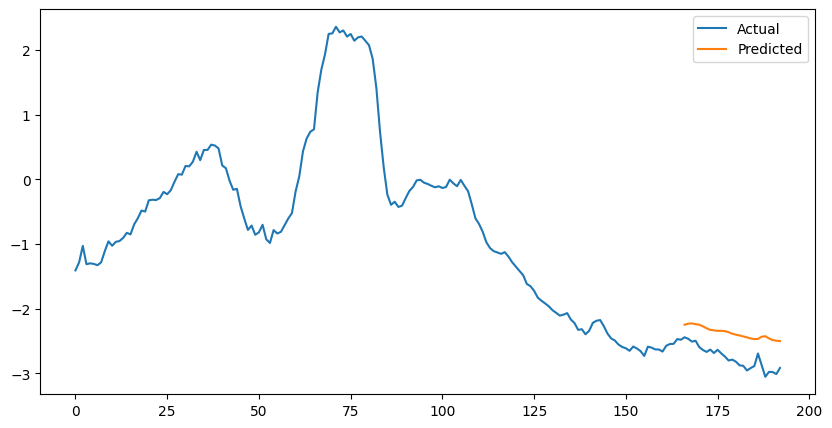

In [23]:
plt.figure(figsize=(10, 5))
plt.plot(np.concatenate((train_df1, val_df1, test_df1), axis=0), label="Actual")
plt.plot(range(166, 193), y_pred_test.numpy(),label="Predicted")
plt.legend()
plt.show()

In [24]:
column_indices = {name: i for i, name in enumerate(second_piece.columns)}
n = len(second_piece)
train_df2 =second_piece[0:int(n*0.6)]
val_df2 = second_piece[int(n*0.6):int(n*0.8)]
test_df2 = second_piece[int(n*0.8):]

In [25]:
# Normalize the data (each partition separately)
train_mean2 = train_df2.mean()
train_std2 = train_df2.std()

train_df2 = (train_df2 - train_mean2) / train_std2
val_df2 = (val_df2 - train_mean2) / train_std2
test_df2 = (test_df2 - train_mean2) / train_std2

In [26]:
train_seq2, train_labels2 = create_sequences(train_df2.values, 12)
val_seq2, val_labels2 = create_sequences(val_df2.values, 12)
test_seq2, test_labels2 = create_sequences(test_df2.values, 12)
# Convert to PyTorch tensors
train_seq_tensor2 = torch.FloatTensor(train_seq2)  # (batch, seq_length, input_dim)
train_label_tensor2 = torch.FloatTensor(train_labels2) # (batch, output_dim)
val_seq_tensor2 = torch.FloatTensor(val_seq2)  # (batch, seq_length, input_dim)
val_label_tensor2 = torch.FloatTensor(val_labels2)  # (batch, output_dim)
test_seq_tensor2 = torch.FloatTensor(test_seq2)  # (batch, seq_length, input_dim)
test_labels_tensor2 = torch.FloatTensor(test_labels2)  # (batch, output_dim)

In [27]:
# Model parameters
input_dim = 1
hidden_dim = 50
num_layers = 2
output_dim = 1

# Instantiate model
model2 = LSTMModel(input_dim, hidden_dim, num_layers, output_dim)
model2 = model2.to("cpu")  # Use "cuda" if you have a GPU
criterion = nn.MSELoss()
optimizer = optim.Adam(model2.parameters(), lr=0.01)

In [28]:
num_epochs = 100
train_losses = []
val_losses = []

for epoch in range(num_epochs):
    model2.train()
    
    optimizer.zero_grad()
    y_pred = model2(train_seq_tensor2)
    
    loss = criterion(y_pred, train_label_tensor2)
    loss.backward()
    optimizer.step()
    
    train_losses.append(loss.item())

    # Validation
    model2.eval()
    with torch.no_grad():
        y_val = model2(val_seq_tensor2)
        val_loss = criterion(y_val, val_label_tensor2)
        val_losses.append(val_loss.item())
    
    if epoch % 10 == 0:
        print(f'Epoch {epoch}, Train Loss: {loss.item()}, Val Loss: {val_loss.item()}')


Epoch 0, Train Loss: 0.9349398612976074, Val Loss: 3.317002534866333
Epoch 10, Train Loss: 0.27824902534484863, Val Loss: 0.8065032958984375
Epoch 20, Train Loss: 0.09842187166213989, Val Loss: 0.5451633334159851
Epoch 30, Train Loss: 0.04056470841169357, Val Loss: 0.20843233168125153
Epoch 40, Train Loss: 0.030821317806839943, Val Loss: 0.15311895310878754
Epoch 50, Train Loss: 0.028675397858023643, Val Loss: 0.0848710685968399
Epoch 60, Train Loss: 0.02636154554784298, Val Loss: 0.0799705982208252
Epoch 70, Train Loss: 0.02457020804286003, Val Loss: 0.05145101994276047
Epoch 80, Train Loss: 0.02293003909289837, Val Loss: 0.05438067391514778
Epoch 90, Train Loss: 0.021528949961066246, Val Loss: 0.053069282323122025


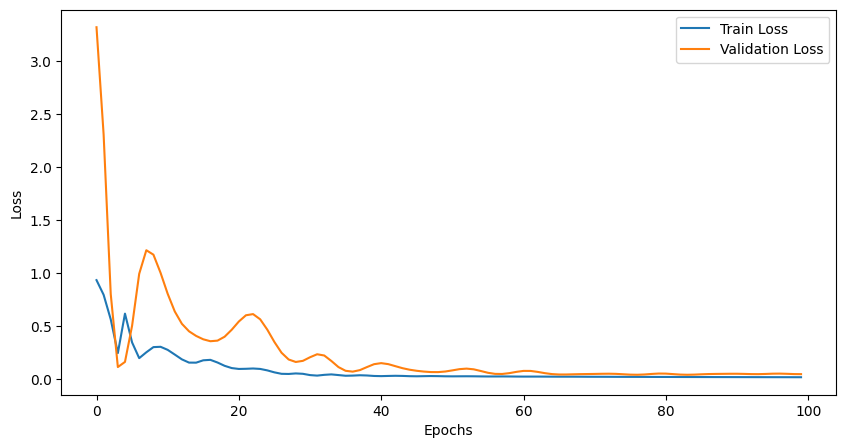

In [29]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()


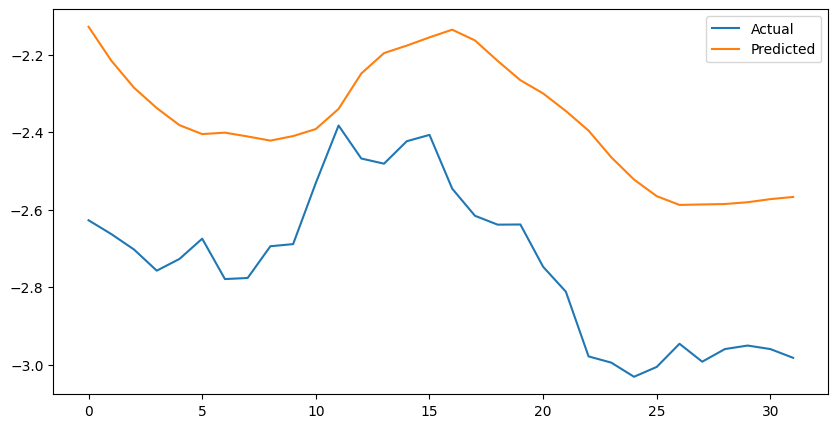

In [30]:
model2.eval()
with torch.no_grad():
    y_pred_test = model2(test_seq_tensor2)

# Plot test predictions
plt.figure(figsize=(10, 5))
plt.plot(test_labels_tensor2.numpy(), label="Actual")
plt.plot(y_pred_test.numpy(), label="Predicted")
plt.legend()
plt.show()


In [31]:
mae = criterion(y_pred_test, test_labels_tensor2)
print(f'Mean Absolute Error: {mae.item()}')
print(f'MARE: {MARE(y_pred_test, test_labels_tensor2)}')

Mean Absolute Error: 0.14906352758407593
MARE: 0.13369496166706085


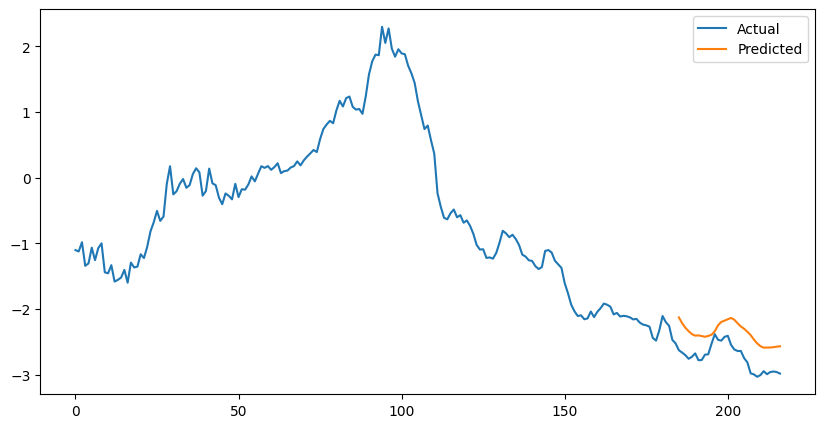

In [32]:
plt.figure(figsize=(10, 5))
plt.plot(np.concatenate((train_df2, val_df2, test_df2), axis=0), label="Actual")
plt.plot(range(185, 217), y_pred_test.numpy(),label="Predicted")
plt.legend()
plt.show()

In [33]:
column_indices = {name: i for i, name in enumerate(third_piece.columns)}
n = len(third_piece)
train_df3 =third_piece[0:int(n*0.6)]
val_df3 = third_piece[int(n*0.6):int(n*0.8)]
test_df3 = third_piece[int(n*0.8):]

# Normalize the data (each partition separately)
train_mean3 = train_df3.mean()
train_std3 = train_df3.std()

train_df3 = (train_df3 - train_mean3) / train_std3
val_df3 = (val_df3 - train_mean3) / train_std3
test_df3 = (test_df3 - train_mean3) / train_std3

train_seq3, train_labels3 = create_sequences(train_df3.values, 12)
val_seq3, val_labels3 = create_sequences(val_df3.values, 12)
test_seq3, test_labels3 = create_sequences(test_df3.values, 12)
# Convert to PyTorch tensors
train_seq_tensor3 = torch.FloatTensor(train_seq3)  # (batch, seq_length, input_dim)
train_label_tensor3 = torch.FloatTensor(train_labels3) # (batch, output_dim)
val_seq_tensor3 = torch.FloatTensor(val_seq3)  # (batch, seq_length, input_dim)
val_label_tensor3 = torch.FloatTensor(val_labels3)  # (batch, output_dim)
test_seq_tensor3 = torch.FloatTensor(test_seq3)  # (batch, seq_length, input_dim)
test_labels_tensor3 = torch.FloatTensor(test_labels3)  # (batch, output_dim)

In [34]:
# Model parameters
input_dim = 1
hidden_dim = 50
num_layers = 2
output_dim = 1

# Instantiate model
model3 = LSTMModel(input_dim, hidden_dim, num_layers, output_dim)
model3 = model3.to("cpu")  # Use "cuda" if you have a GPU
criterion = nn.MSELoss()
optimizer = optim.Adam(model3.parameters(), lr=0.01)

In [35]:
num_epochs = 100
train_losses = []
val_losses = []

for epoch in range(num_epochs):
    model3.train()
    
    optimizer.zero_grad()
    y_pred = model3(train_seq_tensor3)
    
    loss = criterion(y_pred, train_label_tensor3)
    loss.backward()
    optimizer.step()
    
    train_losses.append(loss.item())

    # Validation
    model3.eval()
    with torch.no_grad():
        y_val = model3(val_seq_tensor3)
        val_loss = criterion(y_val, val_label_tensor3)
        val_losses.append(val_loss.item())
    
    if epoch % 10 == 0:
        print(f'Epoch {epoch}, Train Loss: {loss.item()}, Val Loss: {val_loss.item()}')


Epoch 0, Train Loss: 0.9082831740379333, Val Loss: 0.30719515681266785
Epoch 10, Train Loss: 0.14418664574623108, Val Loss: 0.25984179973602295
Epoch 20, Train Loss: 0.05780710652470589, Val Loss: 0.07675115019083023
Epoch 30, Train Loss: 0.034995656460523605, Val Loss: 0.016193171963095665
Epoch 40, Train Loss: 0.02606022357940674, Val Loss: 0.012561822310090065
Epoch 50, Train Loss: 0.021946705877780914, Val Loss: 0.0117458151653409
Epoch 60, Train Loss: 0.01931949146091938, Val Loss: 0.010925795882940292
Epoch 70, Train Loss: 0.018427008762955666, Val Loss: 0.009569661691784859
Epoch 80, Train Loss: 0.018056966364383698, Val Loss: 0.009215954691171646
Epoch 90, Train Loss: 0.017667479813098907, Val Loss: 0.009294298477470875


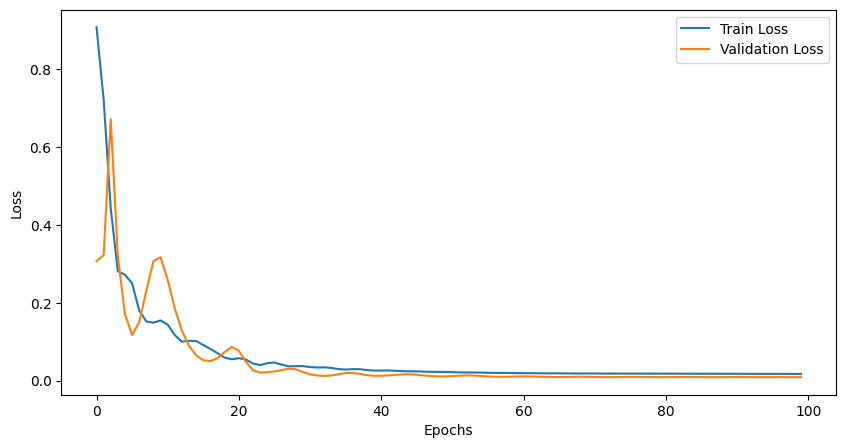

In [36]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()


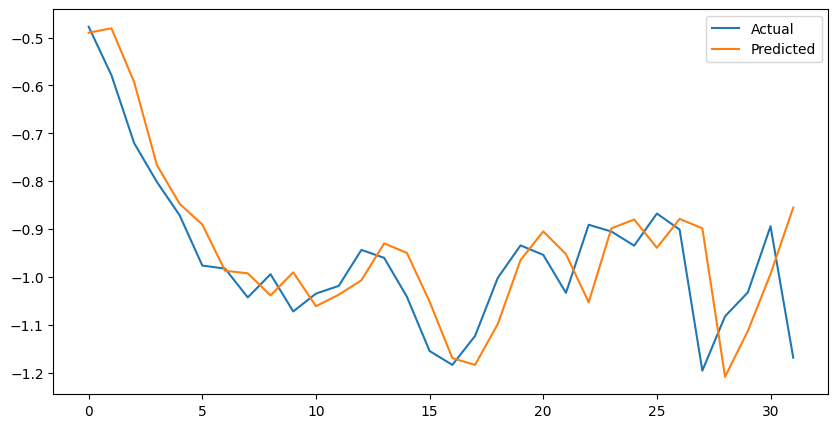

In [37]:
model3.eval()
with torch.no_grad():
    y_pred_test = model3(test_seq_tensor3)

# Plot test predictions
plt.figure(figsize=(10, 5))
plt.plot(test_labels_tensor3.numpy(), label="Actual")
plt.plot(y_pred_test.numpy(), label="Predicted")
plt.legend()
plt.show()


In [38]:
mae = criterion(y_pred_test, test_labels_tensor3)
print(f'Mean Absolute Error: {mae.item()}')
print(f'MARE: {MARE(y_pred_test, test_labels_tensor3)}')

Mean Absolute Error: 0.010882881470024586
MARE: 0.07896606624126434


In [39]:
len(y_pred_test.numpy())

32

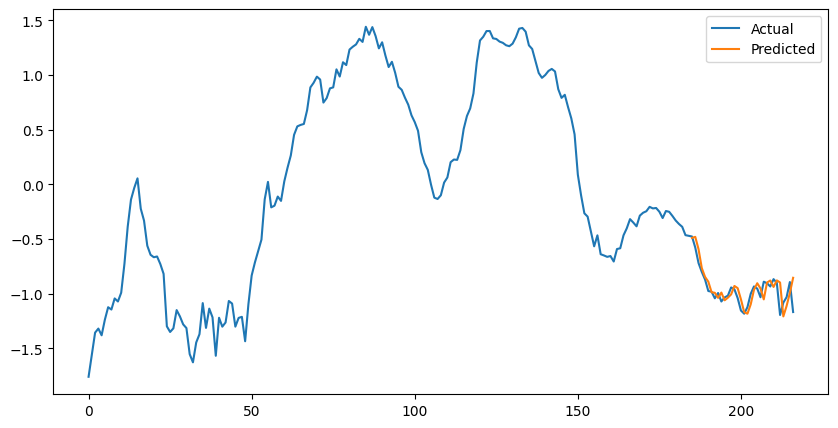

In [40]:
plt.figure(figsize=(10, 5))
plt.plot(np.concatenate((train_df3, val_df3, test_df3), axis=0), label="Actual")
plt.plot(range(185, 217), y_pred_test.numpy(),label="Predicted")
plt.legend()
plt.show()

In [41]:
column_indices = {name: i for i, name in enumerate(second_piece.columns)}
n = len(fourth_piece)
train_df4 =fourth_piece[0:int(n*0.6)]
val_df4 = fourth_piece[int(n*0.6):int(n*0.8)]
test_df4 = fourth_piece[int(n*0.8):]

# Normalize the data (each partition separately)
train_mean4 = train_df4.mean()
train_std4 = train_df4.std()

train_df4 = (train_df4 - train_mean4) / train_std4
val_df4 = (val_df4 - train_mean4) / train_std4
test_df4 = (test_df4 - train_mean4) / train_std4

train_seq4, train_labels4 = create_sequences(train_df4.values, 12)
val_seq4, val_labels4 = create_sequences(val_df4.values, 12)
test_seq4, test_labels4 = create_sequences(test_df4.values, 12)
# Convert to PyTorch tensors
train_seq_tensor4 = torch.FloatTensor(train_seq4)  # (batch, seq_length, input_dim)
train_label_tensor4 = torch.FloatTensor(train_labels4) # (batch, output_dim)
val_seq_tensor4 = torch.FloatTensor(val_seq4)  # (batch, seq_length, input_dim)
val_label_tensor4 = torch.FloatTensor(val_labels4)  # (batch, output_dim)
test_seq_tensor4 = torch.FloatTensor(test_seq4)  # (batch, seq_length, input_dim)
test_labels_tensor4 = torch.FloatTensor(test_labels4)  # (batch, output_dim)

In [42]:
# Model parameters
input_dim = 1
hidden_dim = 50
num_layers = 2
output_dim = 1

# Instantiate model
model4 = LSTMModel(input_dim, hidden_dim, num_layers, output_dim)
model4 = model4.to("cpu")  # Use "cuda" if you have a GPU
criterion = nn.MSELoss()
optimizer = optim.Adam(model4.parameters(), lr=0.01)

In [43]:
num_epochs = 100
train_losses = []
val_losses = []

for epoch in range(num_epochs):
    model4.train()
    
    optimizer.zero_grad()
    y_pred = model4(train_seq_tensor4)
    
    loss = criterion(y_pred, train_label_tensor4)
    loss.backward()
    optimizer.step()
    
    train_losses.append(loss.item())

    # Validation
    model3.eval()
    with torch.no_grad():
        y_val = model4(val_seq_tensor4)
        val_loss = criterion(y_val, val_label_tensor4)
        val_losses.append(val_loss.item())
    
    if epoch % 10 == 0:
        print(f'Epoch {epoch}, Train Loss: {loss.item()}, Val Loss: {val_loss.item()}')


Epoch 0, Train Loss: 0.6017679572105408, Val Loss: 2.999579429626465
Epoch 10, Train Loss: 0.22176600992679596, Val Loss: 1.1977696418762207
Epoch 20, Train Loss: 0.06375735253095627, Val Loss: 0.45258358120918274
Epoch 30, Train Loss: 0.03582129627466202, Val Loss: 0.1820123791694641
Epoch 40, Train Loss: 0.02523825876414776, Val Loss: 0.2033585011959076
Epoch 50, Train Loss: 0.01777169108390808, Val Loss: 0.09055325388908386
Epoch 60, Train Loss: 0.015980998054146767, Val Loss: 0.0401000902056694
Epoch 70, Train Loss: 0.01483561098575592, Val Loss: 0.028076093643903732
Epoch 80, Train Loss: 0.014053036458790302, Val Loss: 0.03393154963850975
Epoch 90, Train Loss: 0.013248229399323463, Val Loss: 0.04459885507822037


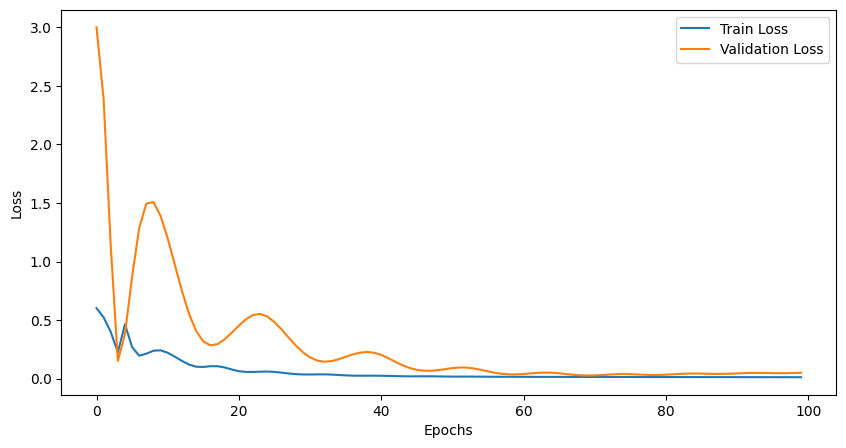

In [44]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()


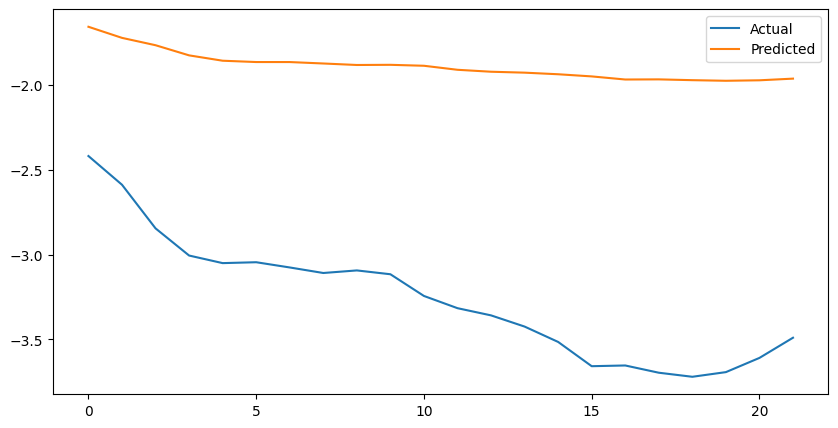

In [45]:
model4.eval()
with torch.no_grad():
    y_pred_test = model4(test_seq_tensor4)

# Plot test predictions
plt.figure(figsize=(10, 5))
plt.plot(test_labels_tensor4.numpy(), label="Actual")
plt.plot(y_pred_test.numpy(), label="Predicted")
plt.legend()
plt.show()


In [46]:
mae = criterion(y_pred_test, test_labels_tensor4)
print(f'Mean Absolute Error: {mae.item()}')
print(f'MARE: {MARE(y_pred_test, test_labels_tensor4)}')

Mean Absolute Error: 1.9549311399459839
MARE: 0.4159950911998749


In [47]:
len(y_pred_test.numpy())

22

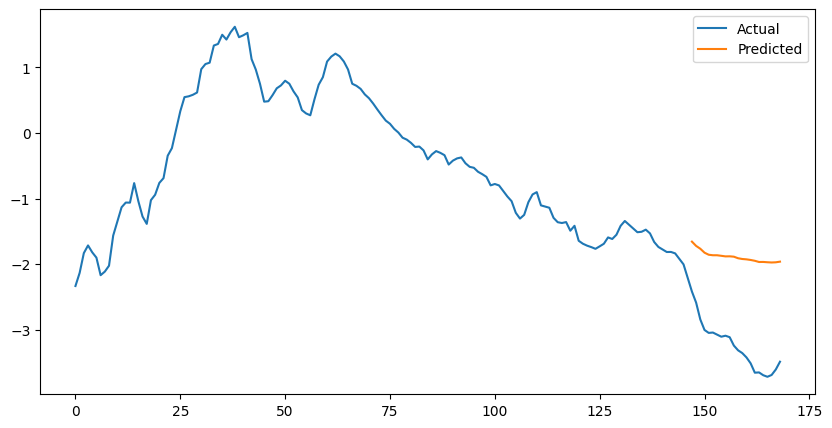

In [48]:
plt.figure(figsize=(10, 5))
plt.plot(np.concatenate((train_df4, val_df4, test_df4), axis=0), label="Actual")
plt.plot(range(147, 169), y_pred_test.numpy(),label="Predicted")
plt.legend()
plt.show()

### Model 1 on other 3 pieces

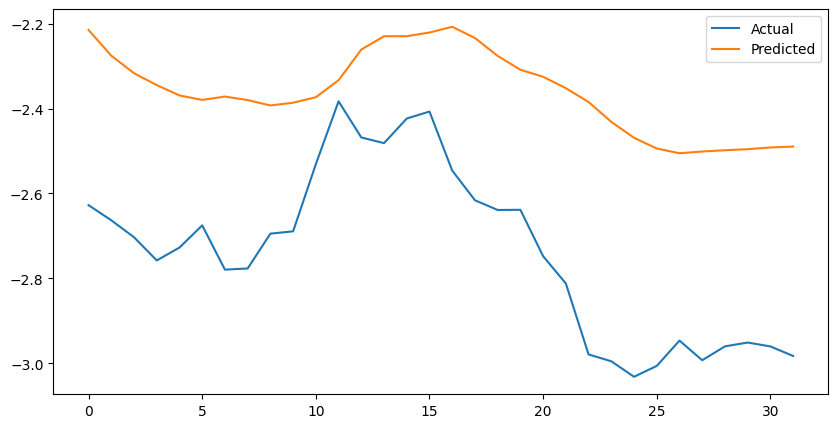

In [49]:
model1.eval()
with torch.no_grad():
    y_pred_test = model1(test_seq_tensor2)

# Plot test predictions
plt.figure(figsize=(10, 5))
plt.plot(test_labels_tensor2.numpy(), label="Actual")
plt.plot(y_pred_test.numpy(), label="Predicted")
plt.legend()
plt.show()


In [50]:
mae = criterion(y_pred_test, test_labels_tensor2)
print(f'Mean Absolute Error: {mae.item()}')
print(f'MARE: {MARE(y_pred_test, test_labels_tensor2)}')

Mean Absolute Error: 0.15703441202640533
MARE: 0.13518556952476501


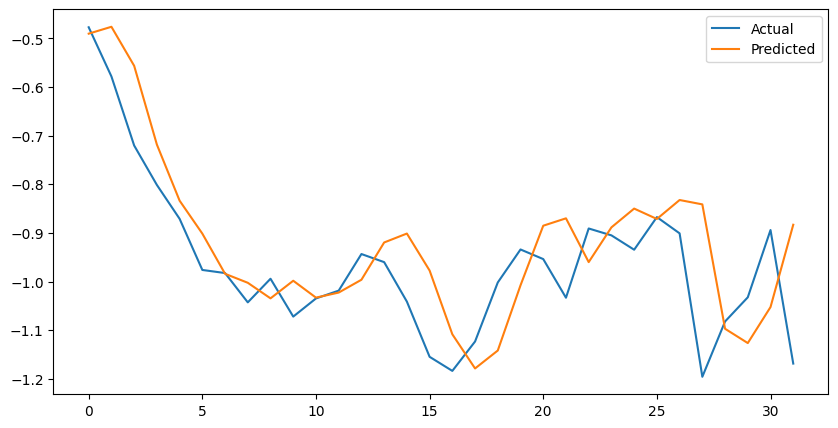

In [51]:
model1.eval()
with torch.no_grad():
    y_pred_test = model1(test_seq_tensor3)

# Plot test predictions
plt.figure(figsize=(10, 5))
plt.plot(test_labels_tensor3.numpy(), label="Actual")
plt.plot(y_pred_test.numpy(), label="Predicted")
plt.legend()
plt.show()

In [52]:
mae = criterion(y_pred_test, test_labels_tensor3)
print(f'Mean Absolute Error: {mae.item()}')
print(f'MARE: {MARE(y_pred_test, test_labels_tensor3)}')

Mean Absolute Error: 0.013702258467674255
MARE: 0.08893165737390518


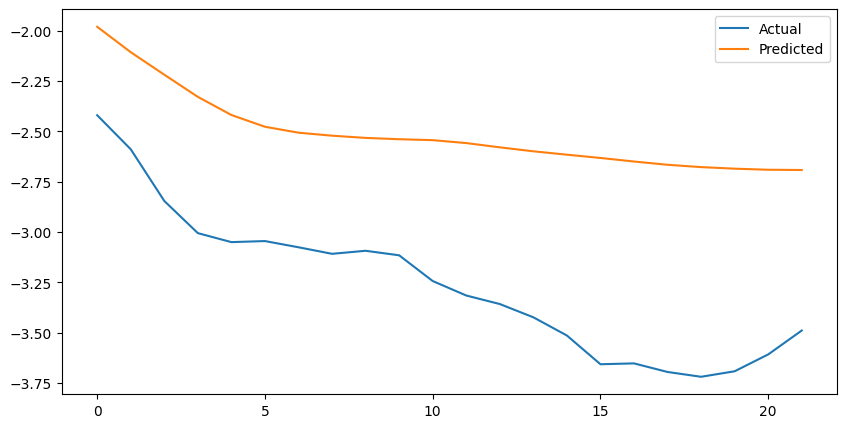

In [53]:
model1.eval()
with torch.no_grad():
    y_pred_test = model1(test_seq_tensor4)

# Plot test predictions
plt.figure(figsize=(10, 5))
plt.plot(test_labels_tensor4.numpy(), label="Actual")
plt.plot(y_pred_test.numpy(), label="Predicted")
plt.legend()
plt.show()

In [54]:
mae = criterion(y_pred_test, test_labels_tensor4)
print(f'Mean Absolute Error: {mae.item()}')
print(f'MARE: {MARE(y_pred_test, test_labels_tensor4)}')

Mean Absolute Error: 0.5993385910987854
MARE: 0.22695527970790863


### Model 2 on 3 other pieces

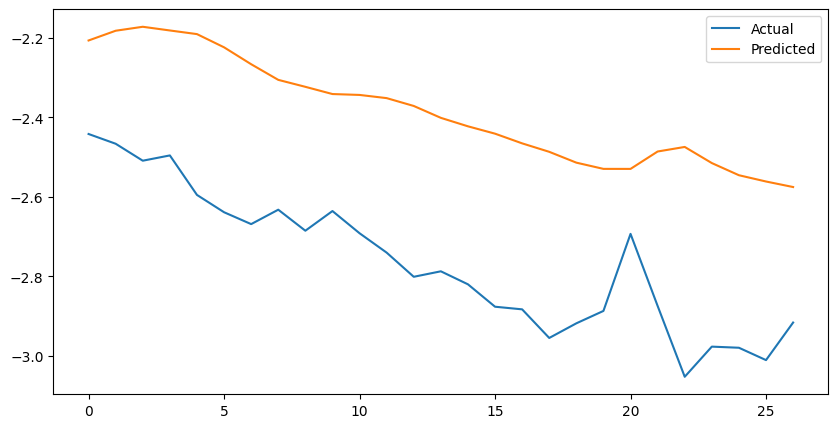

In [55]:
model2.eval()
with torch.no_grad():
    y_pred_test = model2(test_seq_tensor1)

# Plot test predictions
plt.figure(figsize=(10, 5))
plt.plot(test_labels_tensor1.numpy(), label="Actual")
plt.plot(y_pred_test.numpy(), label="Predicted")
plt.legend()
plt.show()

In [56]:
mae = criterion(y_pred_test, test_labels_tensor1)
print(f'Mean Absolute Error: {mae.item()}')
print(f'MARE: {MARE(y_pred_test, test_labels_tensor1)}')

Mean Absolute Error: 0.14971645176410675
MARE: 0.1363147497177124


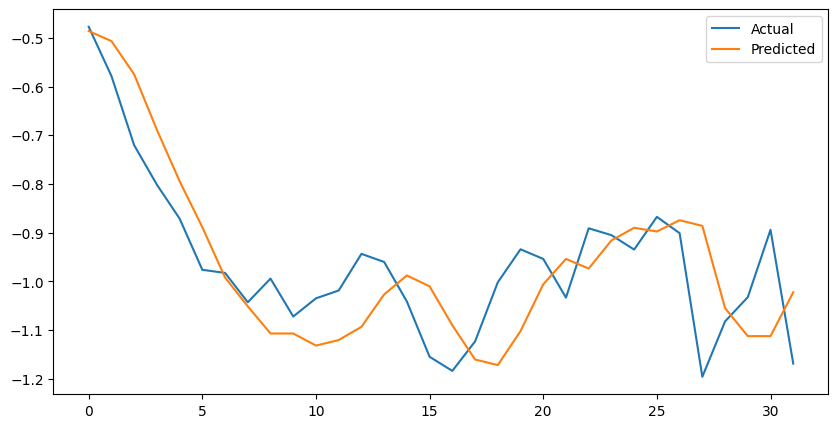

In [57]:
model2.eval()
with torch.no_grad():
    y_pred_test = model2(test_seq_tensor3)

# Plot test predictions
plt.figure(figsize=(10, 5))
plt.plot(test_labels_tensor3.numpy(), label="Actual")
plt.plot(y_pred_test.numpy(), label="Predicted")
plt.legend()
plt.show()

In [58]:
mae = criterion(y_pred_test, test_labels_tensor3)
print(f'Mean Absolute Error: {mae.item()}')
print(f'MARE: {MARE(y_pred_test, test_labels_tensor3)}')

Mean Absolute Error: 0.01237005926668644
MARE: 0.09264223277568817


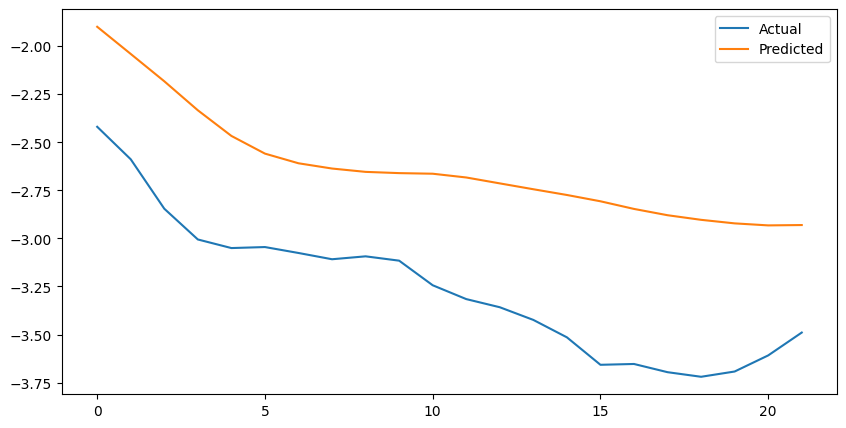

In [59]:
model2.eval()
with torch.no_grad():
    y_pred_test = model2(test_seq_tensor4)

# Plot test predictions
plt.figure(figsize=(10, 5))
plt.plot(test_labels_tensor4.numpy(), label="Actual")
plt.plot(y_pred_test.numpy(), label="Predicted")
plt.legend()
plt.show()

In [60]:
mae = criterion(y_pred_test, test_labels_tensor4)
print(f'Mean Absolute Error: {mae.item()}')
print(f'MARE: {MARE(y_pred_test, test_labels_tensor4)}')

Mean Absolute Error: 0.41421639919281006
MARE: 0.19303470849990845


### Model 3 on other pieces

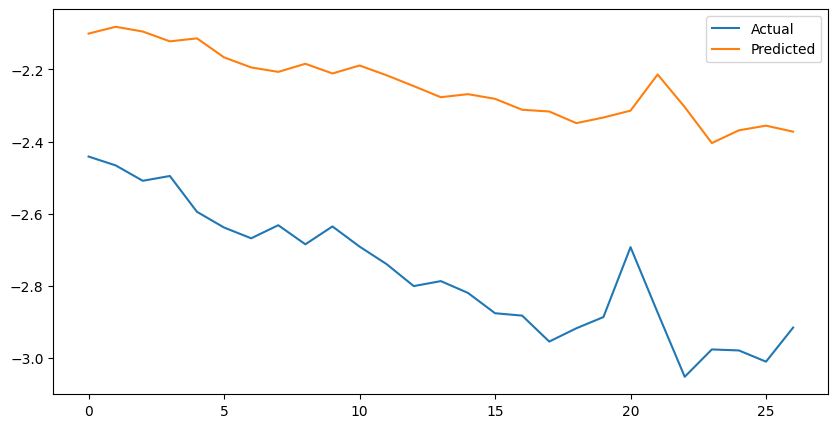

In [61]:
model3.eval()
with torch.no_grad():
    y_pred_test = model3(test_seq_tensor1)

# Plot test predictions
plt.figure(figsize=(10, 5))
plt.plot(test_labels_tensor1.numpy(), label="Actual")
plt.plot(y_pred_test.numpy(), label="Predicted")
plt.legend()
plt.show()

In [62]:
mae = criterion(y_pred_test, test_labels_tensor1)
print(f'Mean Absolute Error: {mae.item()}')
print(f'MARE: {MARE(y_pred_test, test_labels_tensor1)}')

Mean Absolute Error: 0.2795032560825348
MARE: 0.18667246401309967


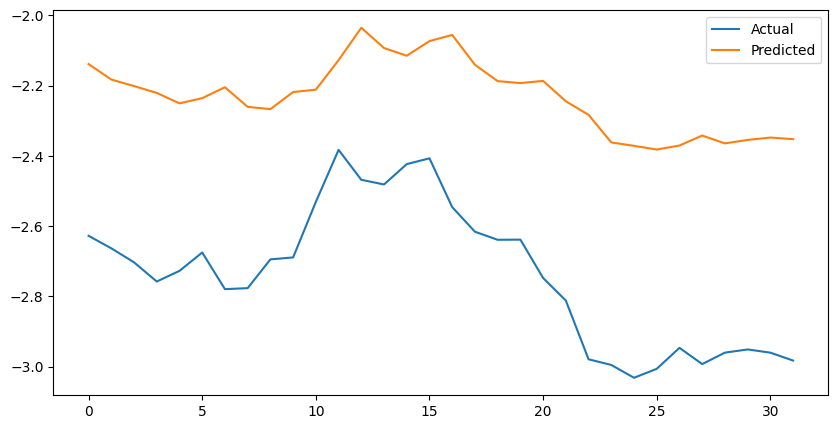

In [63]:
model3.eval()
with torch.no_grad():
    y_pred_test = model3(test_seq_tensor2)

# Plot test predictions
plt.figure(figsize=(10, 5))
plt.plot(test_labels_tensor2.numpy(), label="Actual")
plt.plot(y_pred_test.numpy(), label="Predicted")
plt.legend()
plt.show()

In [64]:
mae = criterion(y_pred_test, test_labels_tensor2)
print(f'Mean Absolute Error: {mae.item()}')
print(f'MARE: {MARE(y_pred_test, test_labels_tensor2)}')

Mean Absolute Error: 0.26841673254966736
MARE: 0.18330521881580353


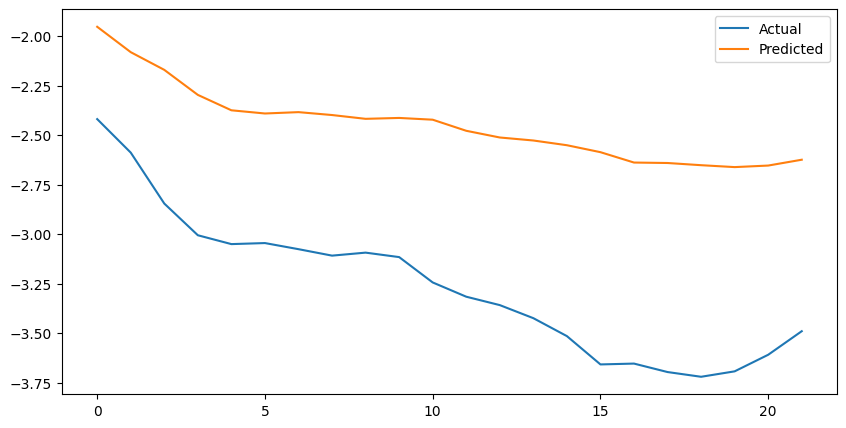

In [65]:
model3.eval()
with torch.no_grad():
    y_pred_test = model3(test_seq_tensor4)

# Plot test predictions
plt.figure(figsize=(10, 5))
plt.plot(test_labels_tensor4.numpy(), label="Actual")
plt.plot(y_pred_test.numpy(), label="Predicted")
plt.legend()
plt.show()

In [66]:
mae = criterion(y_pred_test, test_labels_tensor4)
print(f'Mean Absolute Error: {mae.item()}')
print(f'MARE: {MARE(y_pred_test, test_labels_tensor4)}')

Mean Absolute Error: 0.6919446587562561
MARE: 0.2464950531721115


### Model 4 on other 3 pieces

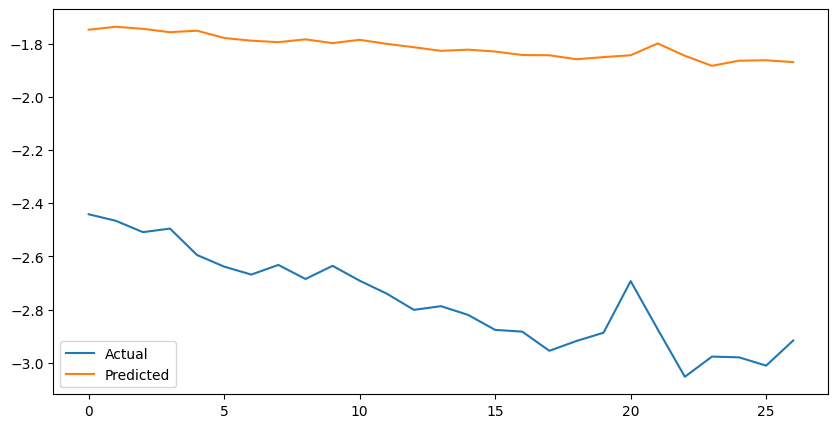

In [67]:
model4.eval()
with torch.no_grad():
    y_pred_test = model4(test_seq_tensor1)

# Plot test predictions
plt.figure(figsize=(10, 5))
plt.plot(test_labels_tensor1.numpy(), label="Actual")
plt.plot(y_pred_test.numpy(), label="Predicted")
plt.legend()
plt.show()

In [68]:
mae = criterion(y_pred_test, test_labels_tensor1)
print(f'Mean Absolute Error: {mae.item()}')
print(f'MARE: {MARE(y_pred_test, test_labels_tensor1)}')

Mean Absolute Error: 0.9244058132171631
MARE: 0.34257972240448


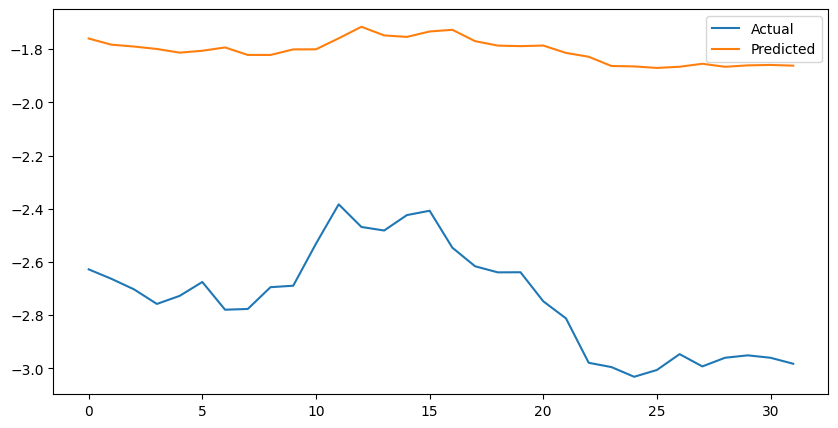

In [69]:
model4.eval()
with torch.no_grad():
    y_pred_test = model4(test_seq_tensor2)

# Plot test predictions
plt.figure(figsize=(10, 5))
plt.plot(test_labels_tensor2.numpy(), label="Actual")
plt.plot(y_pred_test.numpy(), label="Predicted")
plt.legend()
plt.show()

In [70]:
mae = criterion(y_pred_test, test_labels_tensor2)
print(f'Mean Absolute Error: {mae.item()}')
print(f'MARE: {MARE(y_pred_test, test_labels_tensor2)}')

Mean Absolute Error: 0.8931093811988831
MARE: 0.33828288316726685


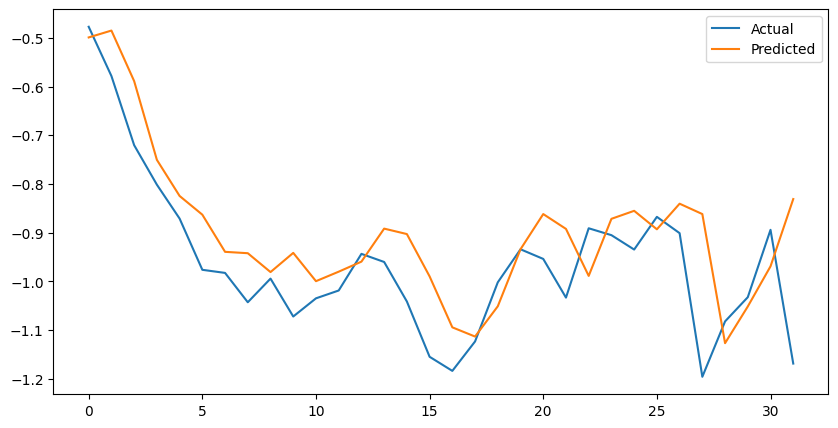

In [71]:
model4.eval()
with torch.no_grad():
    y_pred_test = model4(test_seq_tensor3)

# Plot test predictions
plt.figure(figsize=(10, 5))
plt.plot(test_labels_tensor3.numpy(), label="Actual")
plt.plot(y_pred_test.numpy(), label="Predicted")
plt.legend()
plt.show()

In [72]:
mae = criterion(y_pred_test, test_labels_tensor3)
print(f'Mean Absolute Error: {mae.item()}')
print(f'MARE: {MARE(y_pred_test, test_labels_tensor3)}')

Mean Absolute Error: 0.013156438246369362
MARE: 0.08566278219223022


In [73]:
import copy

### Now let's average all the models

In [74]:
average_model = copy.deepcopy(model1)
models = [model1, model2, model3, model4]
# Compute the average of the parameters
with torch.no_grad():
    for params in zip(*[model.parameters() for model in models]):  # Iterate over corresponding parameters
        avg_param = sum(params) / len(models)  # Element-wise average
        params[0].copy_(avg_param)  # Assign averaged value to the first model (used as reference)

# The `average_model` now has the averaged parameters

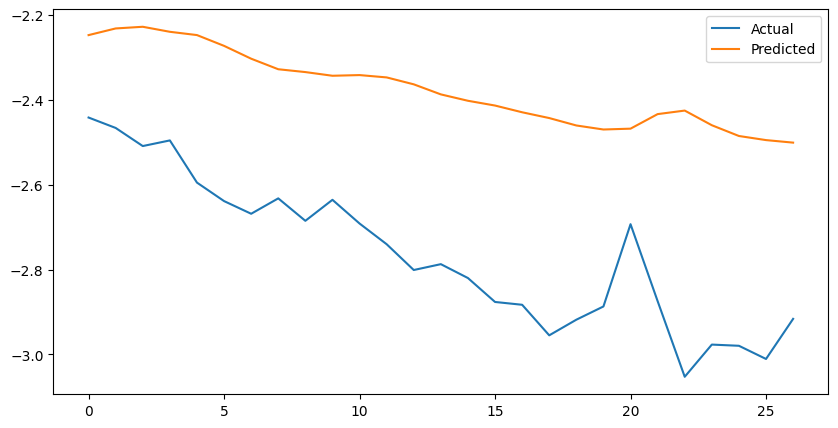

In [75]:
average_model.eval()
with torch.no_grad():
    y_pred_test = average_model(test_seq_tensor1)

# Plot test predictions
plt.figure(figsize=(10, 5))
plt.plot(test_labels_tensor1.numpy(), label="Actual")
plt.plot(y_pred_test.numpy(), label="Predicted")
plt.legend()
plt.show()

In [76]:
mae = criterion(y_pred_test, test_labels_tensor1)
print(f'Mean Absolute Error: {mae.item()}')
print(f'MARE: {MARE(y_pred_test, test_labels_tensor1)}')

Mean Absolute Error: 0.16235654056072235
MARE: 0.13947533071041107


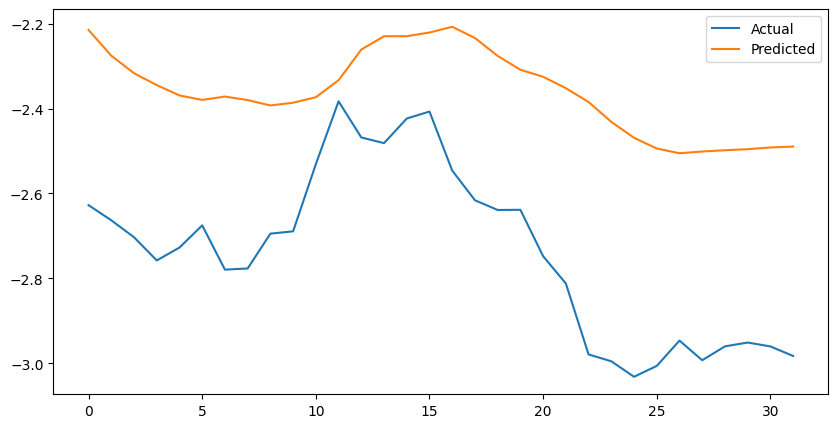

In [77]:
average_model.eval()
with torch.no_grad():
    y_pred_test = average_model(test_seq_tensor2)

# Plot test predictions
plt.figure(figsize=(10, 5))
plt.plot(test_labels_tensor2.numpy(), label="Actual")
plt.plot(y_pred_test.numpy(), label="Predicted")
plt.legend()
plt.show()

In [78]:
mae = criterion(y_pred_test, test_labels_tensor2)
print(f'Mean Absolute Error: {mae.item()}')
print(f'MARE: {MARE(y_pred_test, test_labels_tensor2)}')

Mean Absolute Error: 0.15703441202640533
MARE: 0.13518556952476501


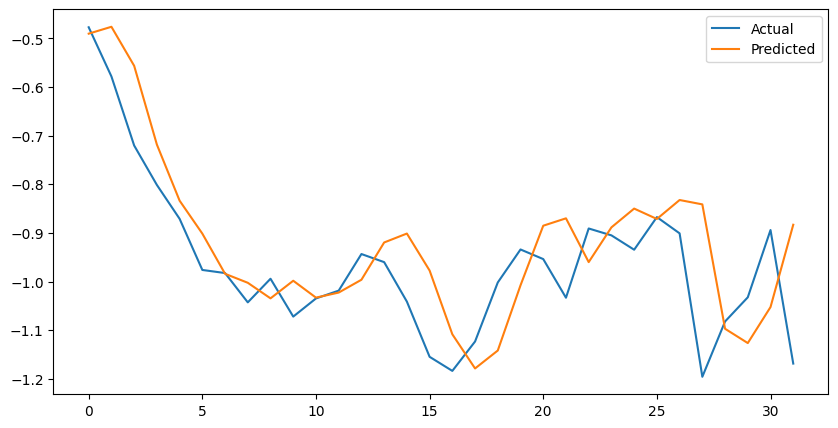

In [79]:
average_model.eval()
with torch.no_grad():
    y_pred_test = average_model(test_seq_tensor3)

# Plot test predictions
plt.figure(figsize=(10, 5))
plt.plot(test_labels_tensor3.numpy(), label="Actual")
plt.plot(y_pred_test.numpy(), label="Predicted")
plt.legend()
plt.show()

In [80]:
mae = criterion(y_pred_test, test_labels_tensor3)
print(f'Mean Absolute Error: {mae.item()}')
print(f'MARE: {MARE(y_pred_test, test_labels_tensor3)}')

Mean Absolute Error: 0.013702258467674255
MARE: 0.08893165737390518


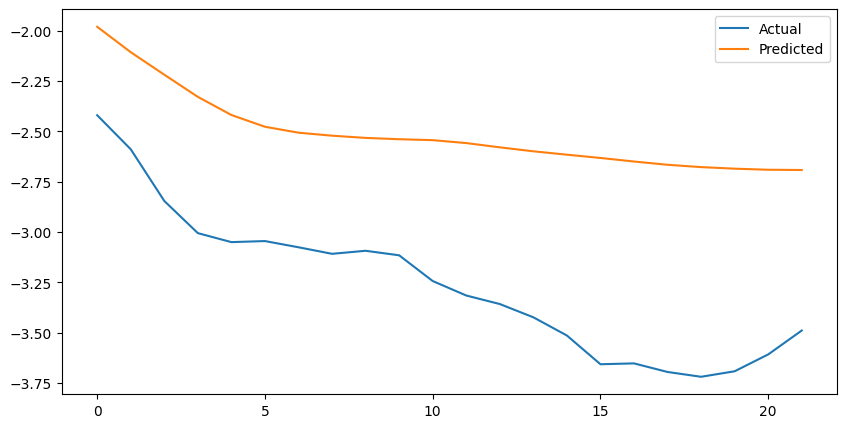

In [81]:
average_model.eval()
with torch.no_grad():
    y_pred_test = average_model(test_seq_tensor4)

# Plot test predictions
plt.figure(figsize=(10, 5))
plt.plot(test_labels_tensor4.numpy(), label="Actual")
plt.plot(y_pred_test.numpy(), label="Predicted")
plt.legend()
plt.show()

In [82]:
mae = criterion(y_pred_test, test_labels_tensor4)
print(f'Mean Absolute Error: {mae.item()}')
print(f'MARE: {MARE(y_pred_test, test_labels_tensor4)}')

Mean Absolute Error: 0.5993385910987854
MARE: 0.22695527970790863


In [83]:
mare = torch.sum(torch.abs((y_pred_test-test_labels_tensor4)/test_labels_tensor4))/len(test_labels_tensor4)

In [85]:
mare.numpy()

array(0.22695528, dtype=float32)